<center>
<h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
Predicting Geothermal Rock Types Using Surface Drilling Parameters: A Machine Learning Approach
</h1>
</center>


In [1]:
"""Package Warning Handling"""
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

"""Data Manipulation and Preparation Packages"""
import numpy as np
import pandas as pd
import missingno as msno 
import lasio
import sys

"""Statistical Packages"""
from scipy import stats
from scipy.stats import chi2_contingency, randint as sp_randint, uniform

"""Data Visualization Packages"""
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

"""Feature Engineering Packages"""
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

"""Model Development Packages"""
from sklearn.model_selection import train_test_split, StratifiedKFold,  GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

"""Model Evaluation Packages"""
from sklearn.metrics import classification_report, roc_auc_score, f1_score, balanced_accuracy_score, \
precision_score, recall_score, roc_curve, make_scorer, average_precision_score, confusion_matrix 

"""Additional Packages"""
from time import time
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

<left>
    <h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
        1. Data Ingestion
    </h1>
</left>

In [2]:
# Reading the well log .LAS file
well_log = lasio.read('58-32_main.las')
print(well_log.curves)

Mnemonic   Unit  Value  Description                                                                                                        
--------   ----  -----  -----------                                                                                                        
DEPT       F            DEPTH (BOREHOLE) {F10.1}                                                                                           
AF10       OHMM         Array Induction Four Foot Resistivity A10 {F11.4}                                                                  
AF20       OHMM         Array Induction Four Foot Resistivity A20 {F11.4}                                                                  
AF30       OHMM         Array Induction Four Foot Resistivity A30 {F11.4}                                                                  
AF60       OHMM         Array Induction Four Foot Resistivity A60 {F11.4}                                                                  
AF90       OHMM     

In [3]:
# Read the well drilling data into pandas dataframe
well_drill_df = pd.read_csv('Well_58-32_processed_pason_log_drilling data.csv')
print(well_drill_df.shape)
print(well_drill_df.columns)
well_drill_df.head(2)

(7311, 27)
Index(['Depth(ft)', 'Depth(m)', 'ROP(1 ft)', 'ROP(1 m)',
       'weight on bit (k-lbs)', 'weight on bit (kg)', 'Temp Out( degF)',
       'Temp Out( degC)', 'Temp In(degF)', 'Temp In(degC)', 'Pit Total (bbls)',
       'Pit Total (m3)', 'Pump Press (psi)', 'Pump Press (KPa)',
       'Hookload (k-lbs)', 'Hookload (kg)', 'Surface Torque (psi)',
       'Surface Torque (KPa)', 'Rotary Speed (rpm)', 'Flow In (gal/min)',
       'Flow In(liters/min)', 'Flow Out %', 'WH Pressure (psi)',
       'WH Pressure (KPa)', 'H2S Floor', 'H2S Cellar', 'H2S Pits'],
      dtype='object')


Depth(ft)  Depth(m)  ROP(1 ft)  ROP(1 m)  weight on bit (k-lbs)  \
0      85.18     25.96      56.80     17.31                    0.0   
1      86.18     26.27      61.14     18.63                    0.0   

   weight on bit (kg)  Temp Out( degF)  Temp Out( degC)  Temp In(degF)  \
0                 0.0            93.49            34.16          90.87   
1                 0.0            93.52            34.18          90.83   

   Temp In(degC)  Pit Total (bbls)  Pit Total (m3)  Pump Press (psi)  \
0          32.71            274.83           43.69            463.72   
1          32.68            274.83           43.69            459.53   

   Pump Press (KPa)  Hookload (k-lbs)  Hookload (kg)  Surface Torque (psi)  \
0           3197.35             31.77       14408.16                  8.93   
1           3168.46             31.01       14063.49                  8.93   

   Surface Torque (KPa)  Rotary Speed (rpm)  Flow In (gal/min)  \
0                 61.57              151.09            1109.58   
1                 61.57              151.09            1108.36   

   Flow In(liters/min)  Flow Out %  WH Pressure (psi)  WH Pressure (KPa)  \
0              4200.22      101.61           -1230.69           -8485.61   
1              4195.60      101.70           -1230.69           -8485.61   

   H2S Floor  H2S Cellar  H2S Pits  
0      -0.01       -0.03      0.31  
1      -0.01       -0.04      0.31

### Comments

The drilling and well log data are obtained from the same well, thus we would prepare the both dataframe and join them based on the depth feature in order to map each depth with the corresponding well log and drilling attributes. 

<left>
    <h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
        2. Data Preparation
    </h1>
</left>

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.1. Depth Match Drilling and Well Log Attributes 
        </span>    
    </h5>
</left>

In [4]:
# Convert the Lasio object into pandas dataframe
logdataframe = well_log.df().reset_index()

# Create a data subset which is to be used for the log plotting.
logdataframe = logdataframe[['DEPT', 'GR', 'RHOZ', 'NPHI', 'SP']]

print(logdataframe.shape)
logdataframe.head(2)

(15128, 5)


DEPT        GR    RHOZ  NPHI  SP
0  10.5  160.0384  2.2207   NaN NaN
1  11.0  160.0384  2.2207   NaN NaN

In [5]:
well_drill_df.columns

Index(['Depth(ft)', 'Depth(m)', 'ROP(1 ft)', 'ROP(1 m)',
       'weight on bit (k-lbs)', 'weight on bit (kg)', 'Temp Out( degF)',
       'Temp Out( degC)', 'Temp In(degF)', 'Temp In(degC)', 'Pit Total (bbls)',
       'Pit Total (m3)', 'Pump Press (psi)', 'Pump Press (KPa)',
       'Hookload (k-lbs)', 'Hookload (kg)', 'Surface Torque (psi)',
       'Surface Torque (KPa)', 'Rotary Speed (rpm)', 'Flow In (gal/min)',
       'Flow In(liters/min)', 'Flow Out %', 'WH Pressure (psi)',
       'WH Pressure (KPa)', 'H2S Floor', 'H2S Cellar', 'H2S Pits'],
      dtype='object')

In [6]:
# Rename the features of the well log dataframe
logdataframe = logdataframe.rename(columns={'RHOZ': 'RHOB',
                                            'DEPT': 'DEPTH'})

# Rename the features of the drilling dataframe
well_drill_df = well_drill_df.rename(columns={'Depth(ft)': 'DEPTH',
                                             'ROP(1 ft)': 'ROP',
                                             'Pump Press (psi)': 'Pump_Pressure',
                                             'Surface Torque (psi)': 'Torque',
                                             'Rotary Speed (rpm)': 'RPM',
                                             'Flow In (gal/min)': 'Flow_Rate',
                                            'weight on bit (k-lbs)': 'WOB'})
# Select the subset of the drilling data
well_drill_df = well_drill_df[['DEPTH', 'ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate']]

# Approxiamate the Depth columns in the two dataframes to the nearest whole number
logdataframe['DEPTH'] = np.ceil(logdataframe['DEPTH']) 
well_drill_df['DEPTH'] = np.ceil(well_drill_df['DEPTH'])

# Merge the well log  and drilling dataframes
merge_df = pd.merge(well_drill_df, logdataframe, on = 'DEPTH', how = 'inner')

# Group by 'depth' and calculate the mean for each group
rawdata = merge_df.groupby('DEPTH').mean().reset_index()

print(rawdata.shape)
rawdata.head(2)

(7273, 11)


DEPTH    ROP  WOB  Pump_Pressure  Torque     RPM  Flow_Rate        GR  \
0   86.0  56.80  0.0         463.72    8.93  151.09    1109.58  37.47610   
1   87.0  61.14  0.0         459.53    8.93  151.09    1108.36  43.78395   

      RHOB     NPHI       SP  
0  2.36905  0.71875  77.5000  
1  2.36870  0.79045  77.3047

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.2. Missing Value Detection and Treatment
        </span>    
    </h5>
</left>

DEPTH            0
ROP              0
WOB              0
Pump_Pressure    0
Torque           0
RPM              0
Flow_Rate        0
GR               0
RHOB             0
NPHI             0
SP               0
dtype: int64


<Axes: >

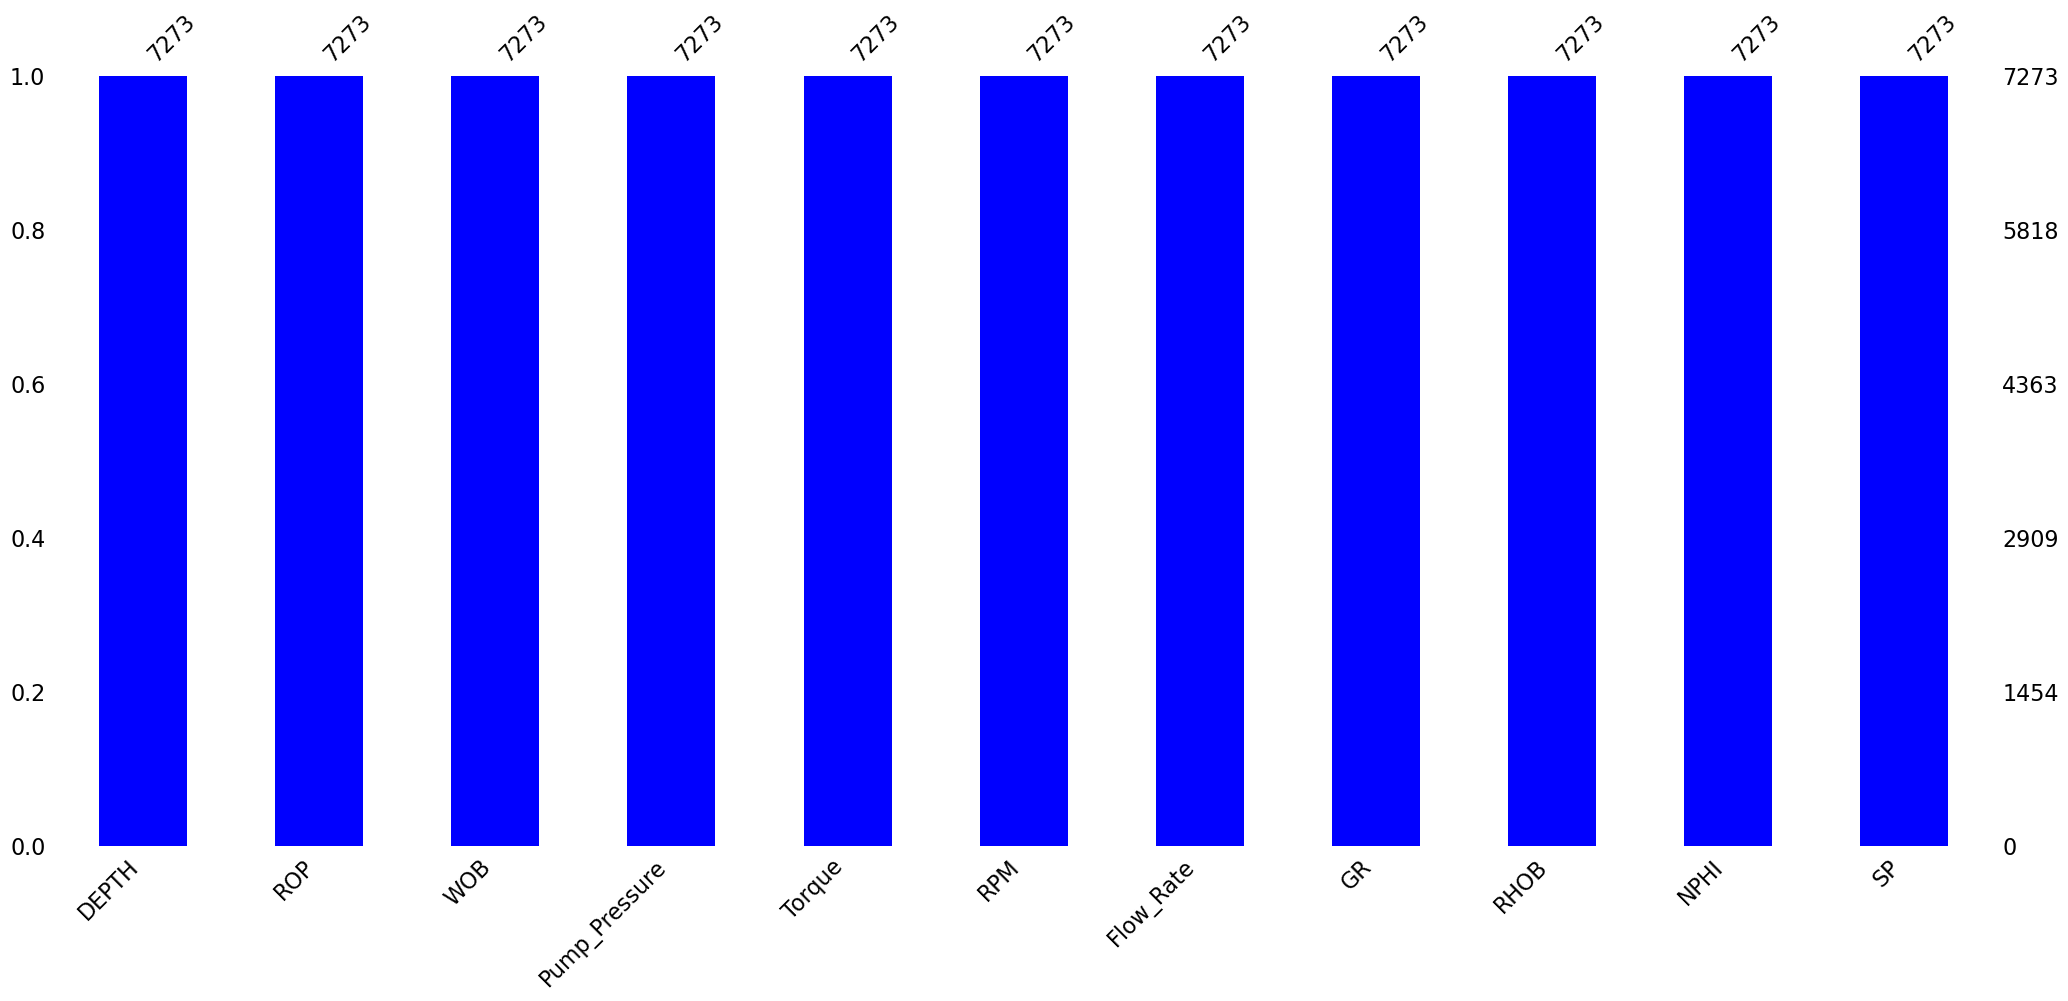

In [7]:
# Visualize the missing values as a matrix
print(rawdata.isna().sum())
msno.bar(rawdata, color="blue")

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.3. Data Type Check and Treatment
        </span>    
    </h5>
</left>

In [8]:
# Check the data types of each column
print("Data types of each column:")
rawdata.dtypes

Data types of each column:


DEPTH            float64
ROP              float64
WOB              float64
Pump_Pressure    float64
Torque           float64
RPM              float64
Flow_Rate        float64
GR               float64
RHOB             float64
NPHI             float64
SP               float64
dtype: object

In [9]:
# Convert Depth column from float to integer
rawdata['DEPTH'] = rawdata['DEPTH'].astype(int)

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.4. Duplicate Detection and Treatment
        </span>    
    </h5>
</left>

In [10]:
# Check for duplicate rows based on all columns
duplicates = rawdata.duplicated(keep=False)  # keep=False marks all duplicates as True
duplicate_rows = rawdata[duplicates]

# Print the result
if duplicate_rows.empty:
    print("No duplicate rows based on all columns.")
else:
    print("Duplicate rows based on all columns:")
    display(duplicate_rows)

No duplicate rows based on all columns.


<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.5. Cardinality Check and Treatment
        </span>    
    </h5>
</left>

In [11]:
def cardinality(df):
    cardinality = {}
    cols = df.columns
    for col in cols:
        cardinality[col] = len(rawdata[col].unique())
    return cardinality
cardinality(rawdata)

{'DEPTH': 7273,
 'ROP': 3380,
 'WOB': 2374,
 'Pump_Pressure': 3350,
 'Torque': 2974,
 'RPM': 3044,
 'Flow_Rate': 3326,
 'GR': 7231,
 'RHOB': 5474,
 'NPHI': 4098,
 'SP': 4646}

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            2.5. Outlier Detection and Treatment
        </span>    
    </h5>
</left>

In [12]:
rawdata.describe()

DEPTH          ROP          WOB  Pump_Pressure       Torque  \
count  7273.000000  7273.000000  7273.000000    7273.000000  7273.000000   
mean   3833.639489    42.098549    23.119210    1265.955673   130.967894   
std    2149.147812    76.080812     9.127467     490.649115    48.677540   
min      86.000000     0.000000     0.000000      19.940000     0.000000   
25%    1967.000000    11.420000    18.310000     665.400000   116.900000   
50%    3847.000000    18.000000    23.830000    1431.440000   140.310000   
75%    5696.000000    44.490000    29.680000    1669.340000   157.280000   
max    7537.000000  2977.910000    47.050000    2200.430000   273.710000   

               RPM    Flow_Rate           GR         RHOB         NPHI  \
count  7273.000000  7273.000000  7273.000000  7273.000000  7273.000000   
mean     54.993196   716.449107   143.921725     2.558172     0.142685   
std      25.944333   141.750246    68.846363     0.259547     0.163645   
min       0.000000     0.000000    22.676900     1.767700    -0.000700   
25%      38.120000   620.260000    86.269800     2.433050     0.013600   
50%      50.380000   700.220000   150.770300     2.570650     0.077450   
75%      76.010000   825.040000   179.598350     2.617600     0.259250   
max     271.580000  3317.510000   636.864300     4.628800     0.856350   

                SP  
count  7273.000000  
mean     40.930776  
std      66.547222  
min    -181.250000  
25%      -1.406250  
50%      50.507800  
75%      77.382800  
max     172.578150

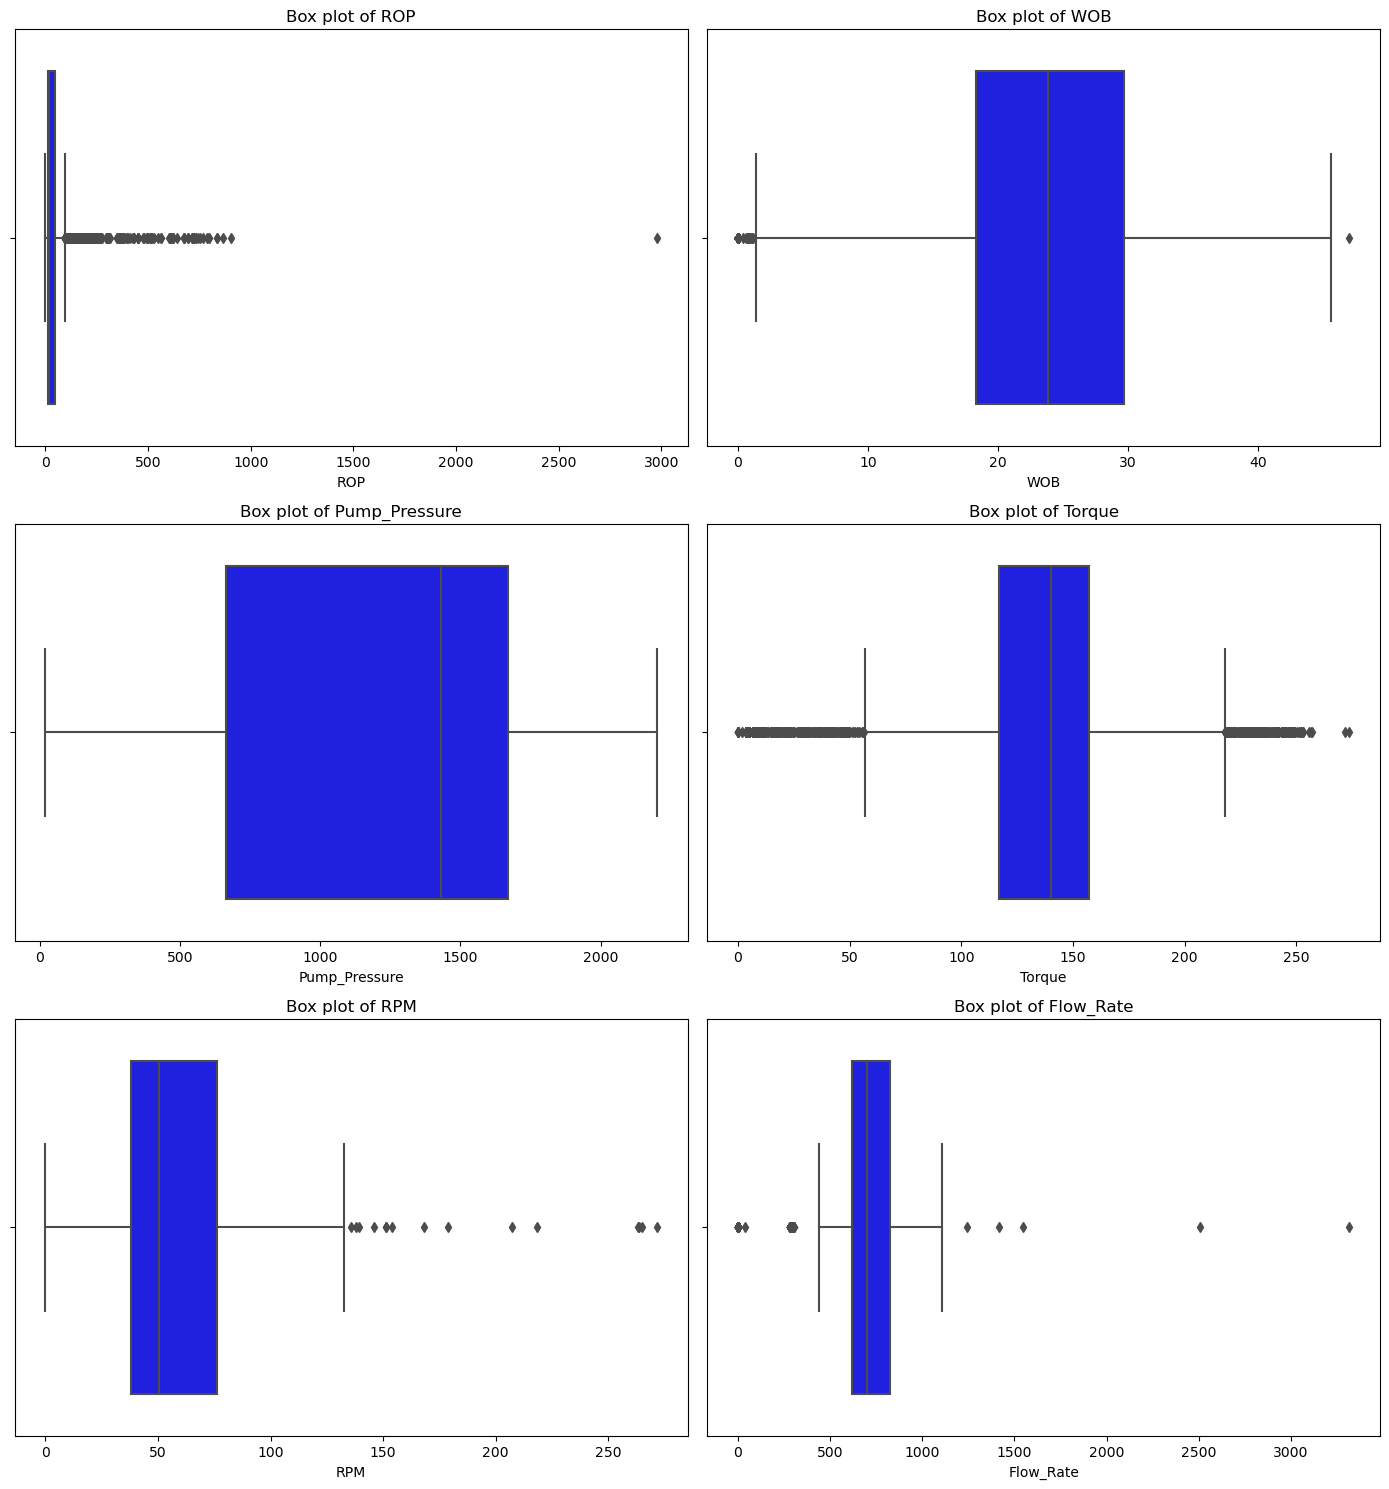

In [13]:
# Function to plot box plots of the respective numerical features
def plot_boxplots(df, cols):
    rows = (len(cols) + 1) // 2  # Calculate the number of rows needed
    plt.figure(figsize=(14, 5 * rows))  # Adjust the figure size accordingly
    for i, col in enumerate(cols):
        plt.subplot(rows, 2, i + 1)  # Create a subplot for each column
        sns.boxplot(x=df[col], color="blue")
        plt.title(f'Box plot of {col}')
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
plotting_columns = ['ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate']    
plot_boxplots(rawdata, plotting_columns)

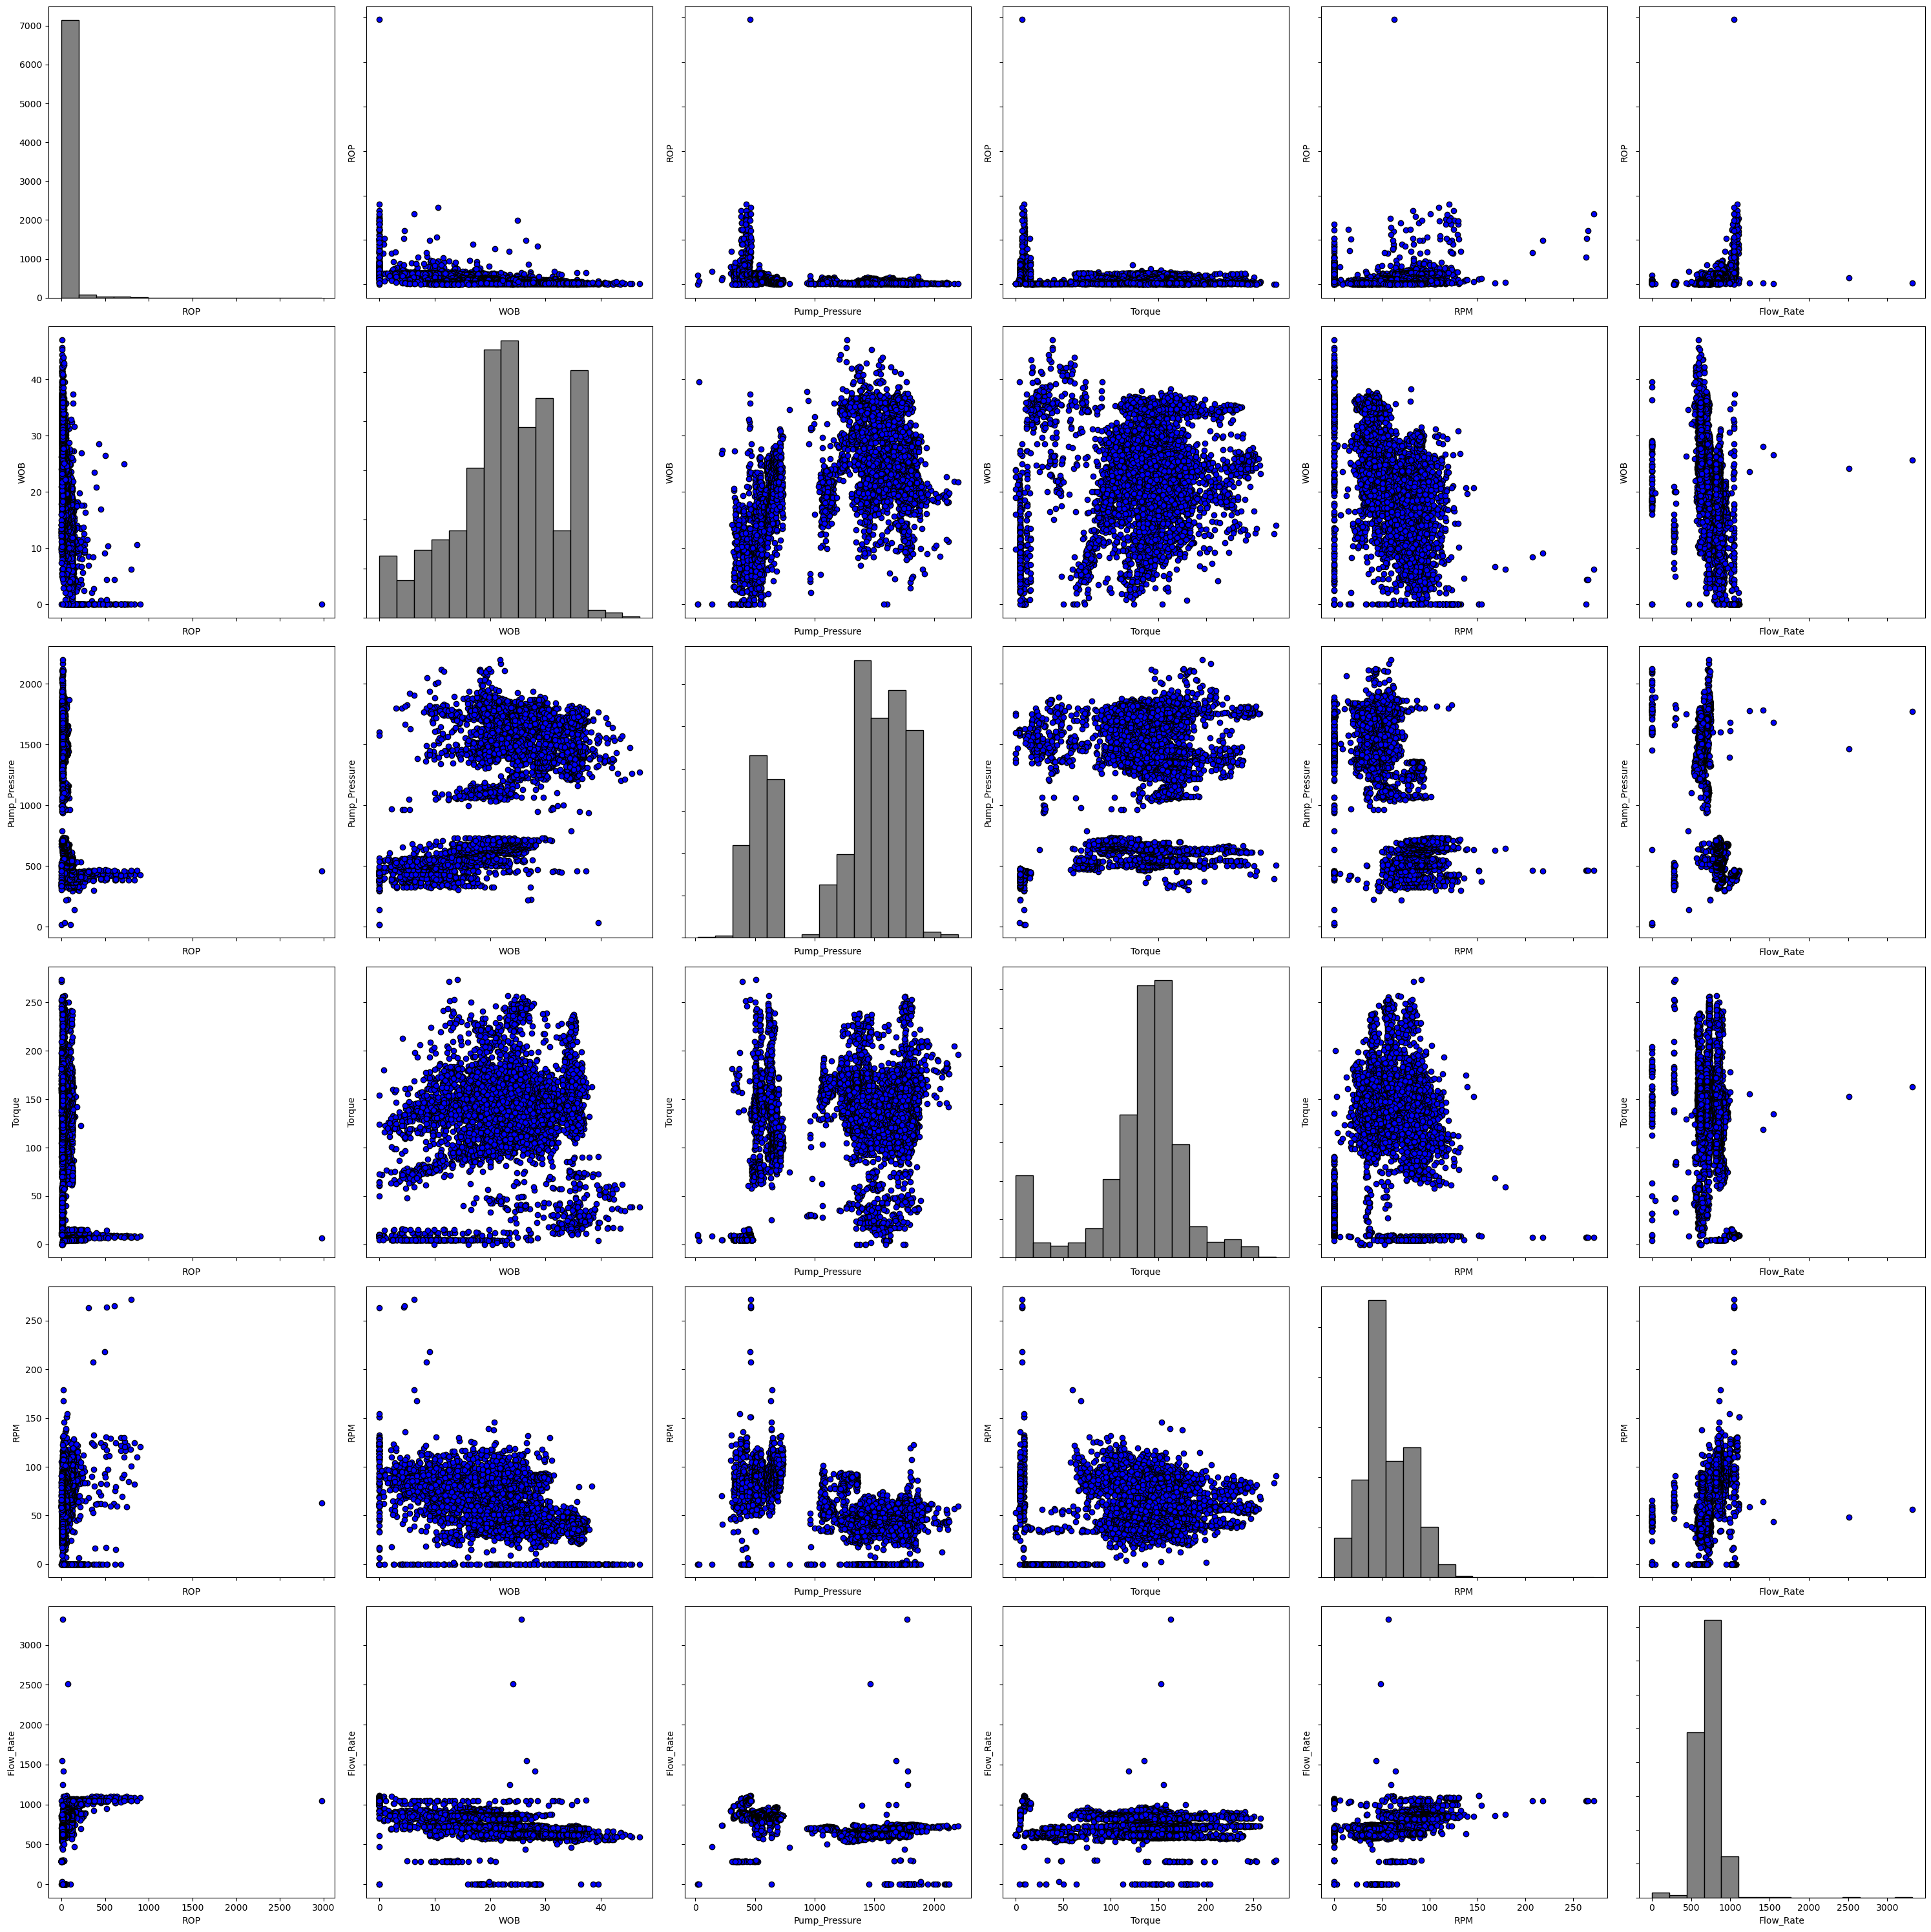

In [14]:
def pair_plot(df, columns):
    """
    Create a pair plot for the specified columns of a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list of str): The list of column names to include in the pair plot.
    """
    # Number of variables
    num_vars = len(columns)

    # Create a figure
    fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(5*num_vars, 5*num_vars))

    # Iterate through rows
    for i, row_var in enumerate(columns):
        for j, col_var in enumerate(columns):
            ax = axes[i][j]
            
            # Plot on diagonal
            if i == j:
                ax.hist(df[row_var], bins=15, color='gray', edgecolor='black')
                ax.set_xlabel(row_var)
            # Plot scatter plot
            else:
                ax.scatter(df[col_var], df[row_var], color='blue', edgecolor='black')
                ax.set_xlabel(col_var)
                ax.set_ylabel(row_var)
            
            # Hide labels unless they are on the left or bottom edges
            if i < num_vars - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])

    # Tight layout to maximize space
    plt.tight_layout()
    plt.show()

pair_plot(rawdata, plotting_columns)

In [15]:
# Based on domain knowledge and observed outliers we will cap
rawdata_ = rawdata[(rawdata['Flow_Rate'] < 1000) & (rawdata['Flow_Rate'] > 450) &
                 (rawdata['RPM'] < 150) & (rawdata['RPM'] > 0) &
                 (rawdata['Pump_Pressure'] > 300) &
                 (rawdata['ROP'] < 150) & (rawdata['ROP'] > 0) &
                 (rawdata['WOB'] > 0) &
                 (rawdata['Torque'] > 20)]
rawdata_.shape

(6411, 11)

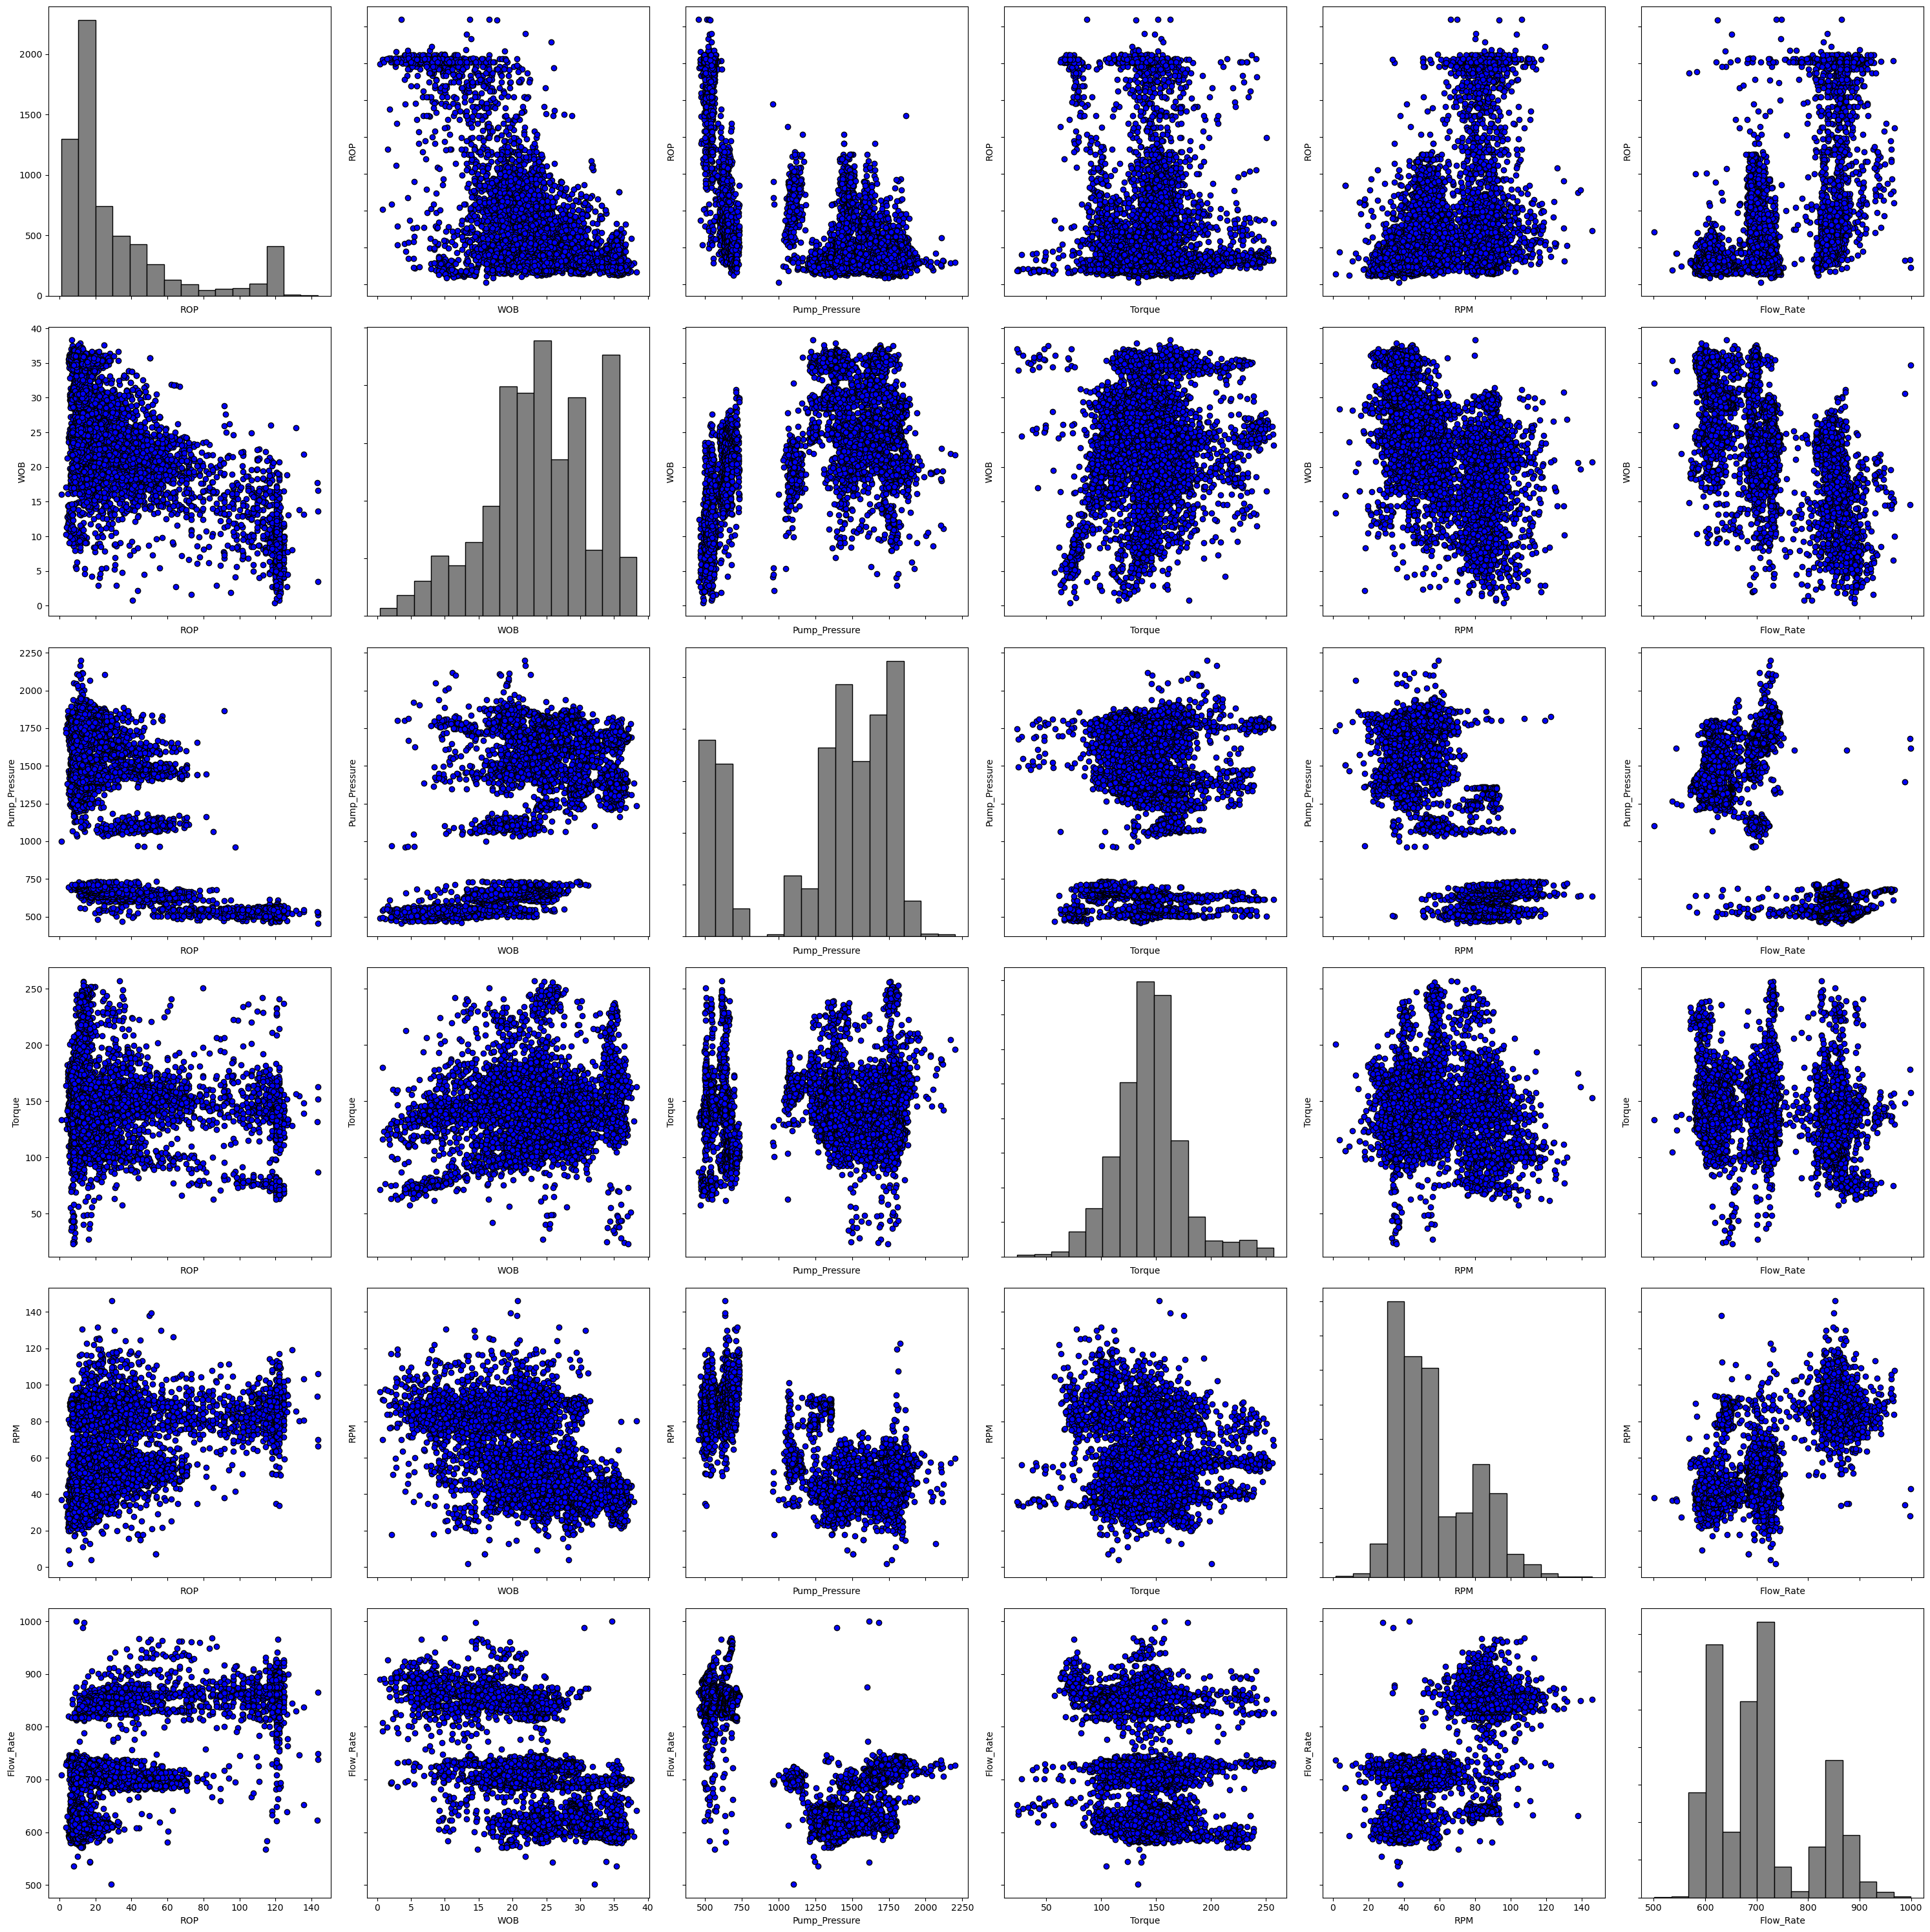

In [16]:
pair_plot(rawdata_, plotting_columns)

<left>
    <h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
        3. Exploratory Data Analysis
    </h1>
</left>

### Comments

* From the Petrography of the Utah FORGE well 58-32 Log report, it is observed that the top section of the well (depth from 0 - about 3250ft) was identified to be an Alluvium lithology, the second section of the well from around 3250ft - 5250ft was identified to be Rhyolite with poor quartz presence and the last section which is greater than the 5250ft to TD was identified to be plutonic rocks. It is important to note, the segmentation of this lithologies were based on an approximation of identified lithologies from the core analysis (Petrography analysis) conducted at different points.

In [17]:
# create a function to assign days in the week based on the associated numbers with 0 being Monday and 6 being sunday
def lithology(i):
    if (i > 0.0 and i<=3250.0):
        return 'Alluvium' 
    elif (i > 3250 and i<=5250):
        return 'Rhyolite'  
    elif (i >5250):
        return 'Plutonic'  

In [18]:
# Apply the function on the day of the update column
rawdata_['rock_type'] = rawdata_['DEPTH'].apply(lithology)
rawdata_.head()

DEPTH     ROP   WOB  Pump_Pressure  Torque    RPM  Flow_Rate        GR  \
480    595  143.58  3.52         456.09   86.86  70.00     865.37  79.16280   
481    596  122.15  2.02         477.44   74.93  96.27     884.45  75.20915   
482    597  118.19  8.70         479.73   87.78  63.19     886.09  76.76465   
483    598  120.41  7.03         479.73   81.87  90.32     883.84  79.94730   
485    600  116.65  4.83         486.21   78.28  85.13     887.94  81.40295   

        RHOB     NPHI        SP rock_type  
480  2.21715  0.37940  53.15970  Alluvium  
481  2.21075  0.41080  53.39845  Alluvium  
482  2.18560  0.49435  53.32030  Alluvium  
483  2.19525  0.46555  54.11025  Alluvium  
485  2.30595  0.38690  59.76565  Alluvium

In [19]:
def log_plot(logs):
    from matplotlib.patches import Patch
    logs = logs.sort_values(by='DEPTH')
    top = logs.DEPTH.min()
    bot = logs.DEPTH.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 10))
    ax[0].plot(logs.GR, logs.DEPTH, color='green')
    ax[1].plot(logs.RHOB, logs.DEPTH, color='orange')
    ax[2].plot(logs.NPHI, logs.DEPTH, color='red')
    ax[3].plot(logs.SP, logs.DEPTH, color='blue')
    
    ax[4].fill_betweenx(logs.DEPTH, x1 = 0, x2=12, where= logs.rock_type == 'Alluvium',color = 'lime')
    ax[4].fill_betweenx(logs.DEPTH, x1 = 0, x2=12, where= logs.rock_type == 'Rhyolite',color = 'black')
    ax[4].fill_betweenx(logs.DEPTH, x1 = 0, x2=12, where= logs.rock_type == 'Plutonic',color = 'red')

    
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        
    ax[0].set_xlabel("GR", fontsize = 16)
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[0].set_ylabel("Depth(ft)",fontsize = 16)
    ax[1].set_xlabel("RHOB", fontsize = 16)
    ax[1].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[2].set_xlabel("NPHI", fontsize = 16)
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("SP", fontsize = 16)
    ax[3].set_xlim(logs.SP.min(),logs.SP.max())
    ax[4].set_xlabel("rock_type", fontsize = 16)
#    ax[4].set_xlim(logs.Facies.min(),logs.Facies1.max())
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([]); ax[4].set_yticklabels([])
    legend_elements = [Patch(facecolor='lime', edgecolor='lime', label='Alluvium'),
                       Patch(facecolor='black', edgecolor='black',   label='Rhyolite'),
                       Patch(facecolor='red', edgecolor='red', label='Plutonic')
                      ]
    ax[4].legend(handles=legend_elements, loc='upper left')
    
    f.suptitle('58-32 Geophysical Log', fontsize=20,y=0.94)

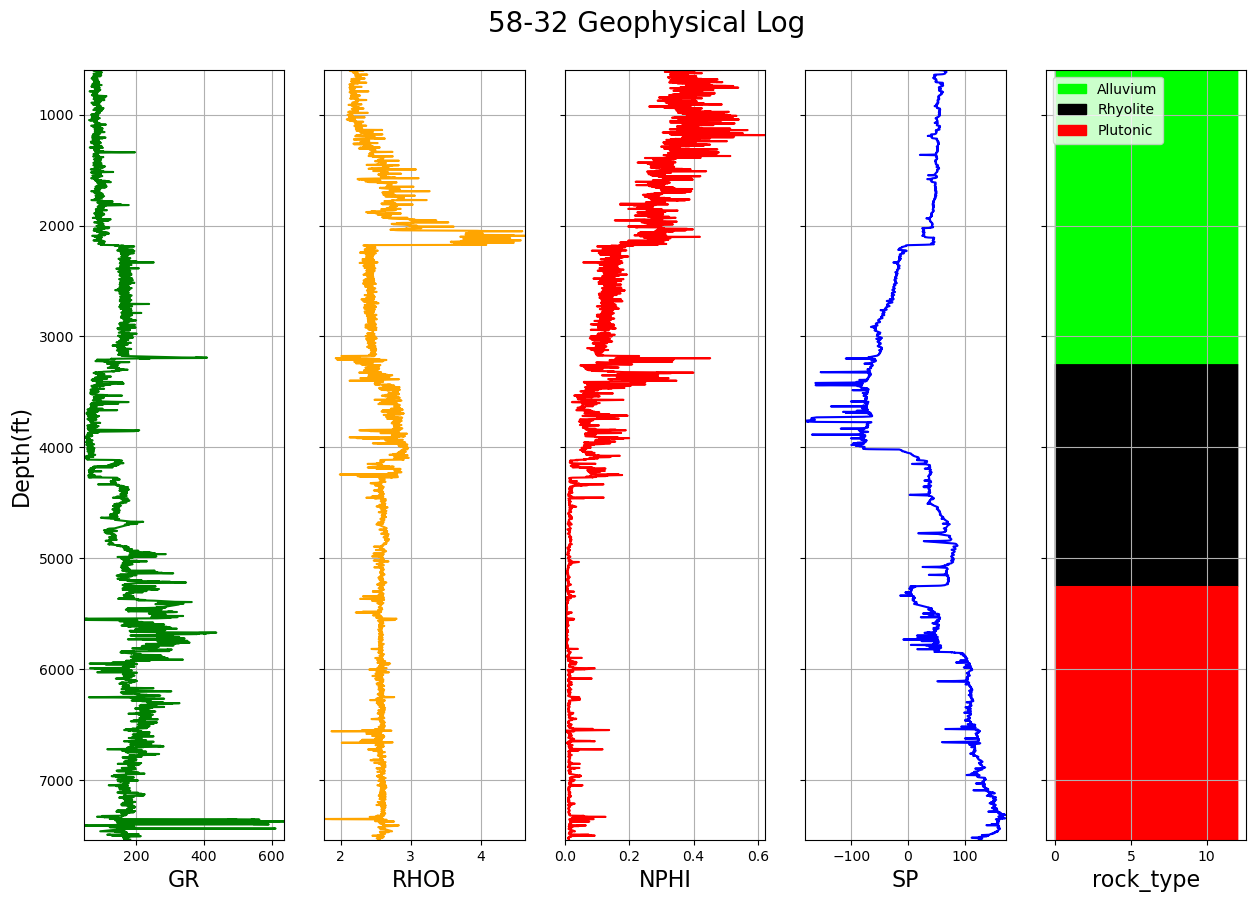

In [20]:
log_plot(rawdata_)

In [21]:
df = rawdata_[['ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate', 'rock_type']]

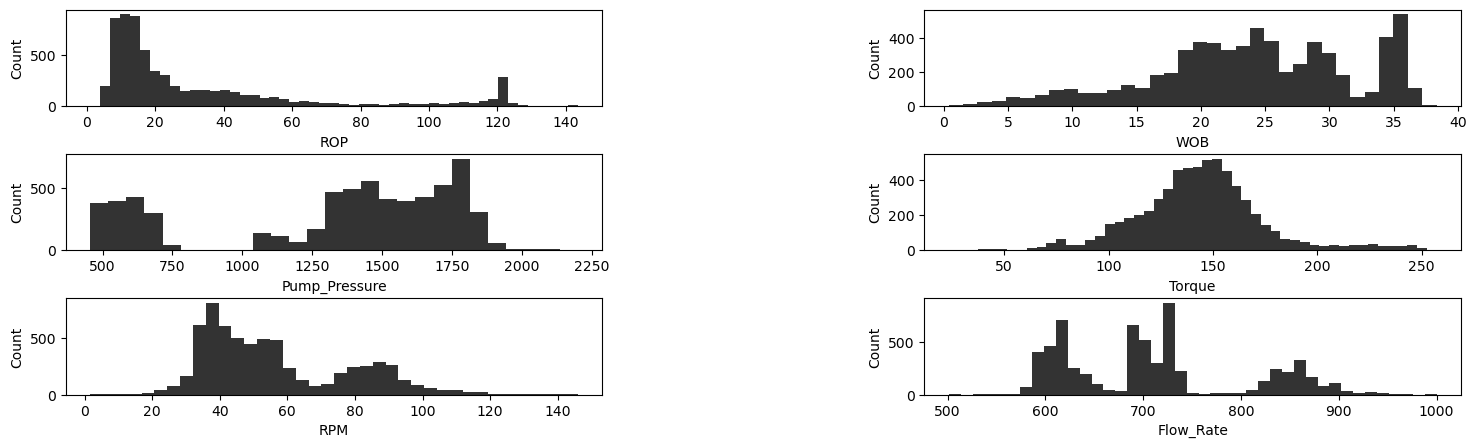

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(18,5))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
for ax, v in zip(axes.flat, ['ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate',]):
    sns.distplot(df[v], kde=False, color="black", 
                 hist_kws={"alpha": 0.8}, ax=ax)
    ax.set(ylabel="Count");

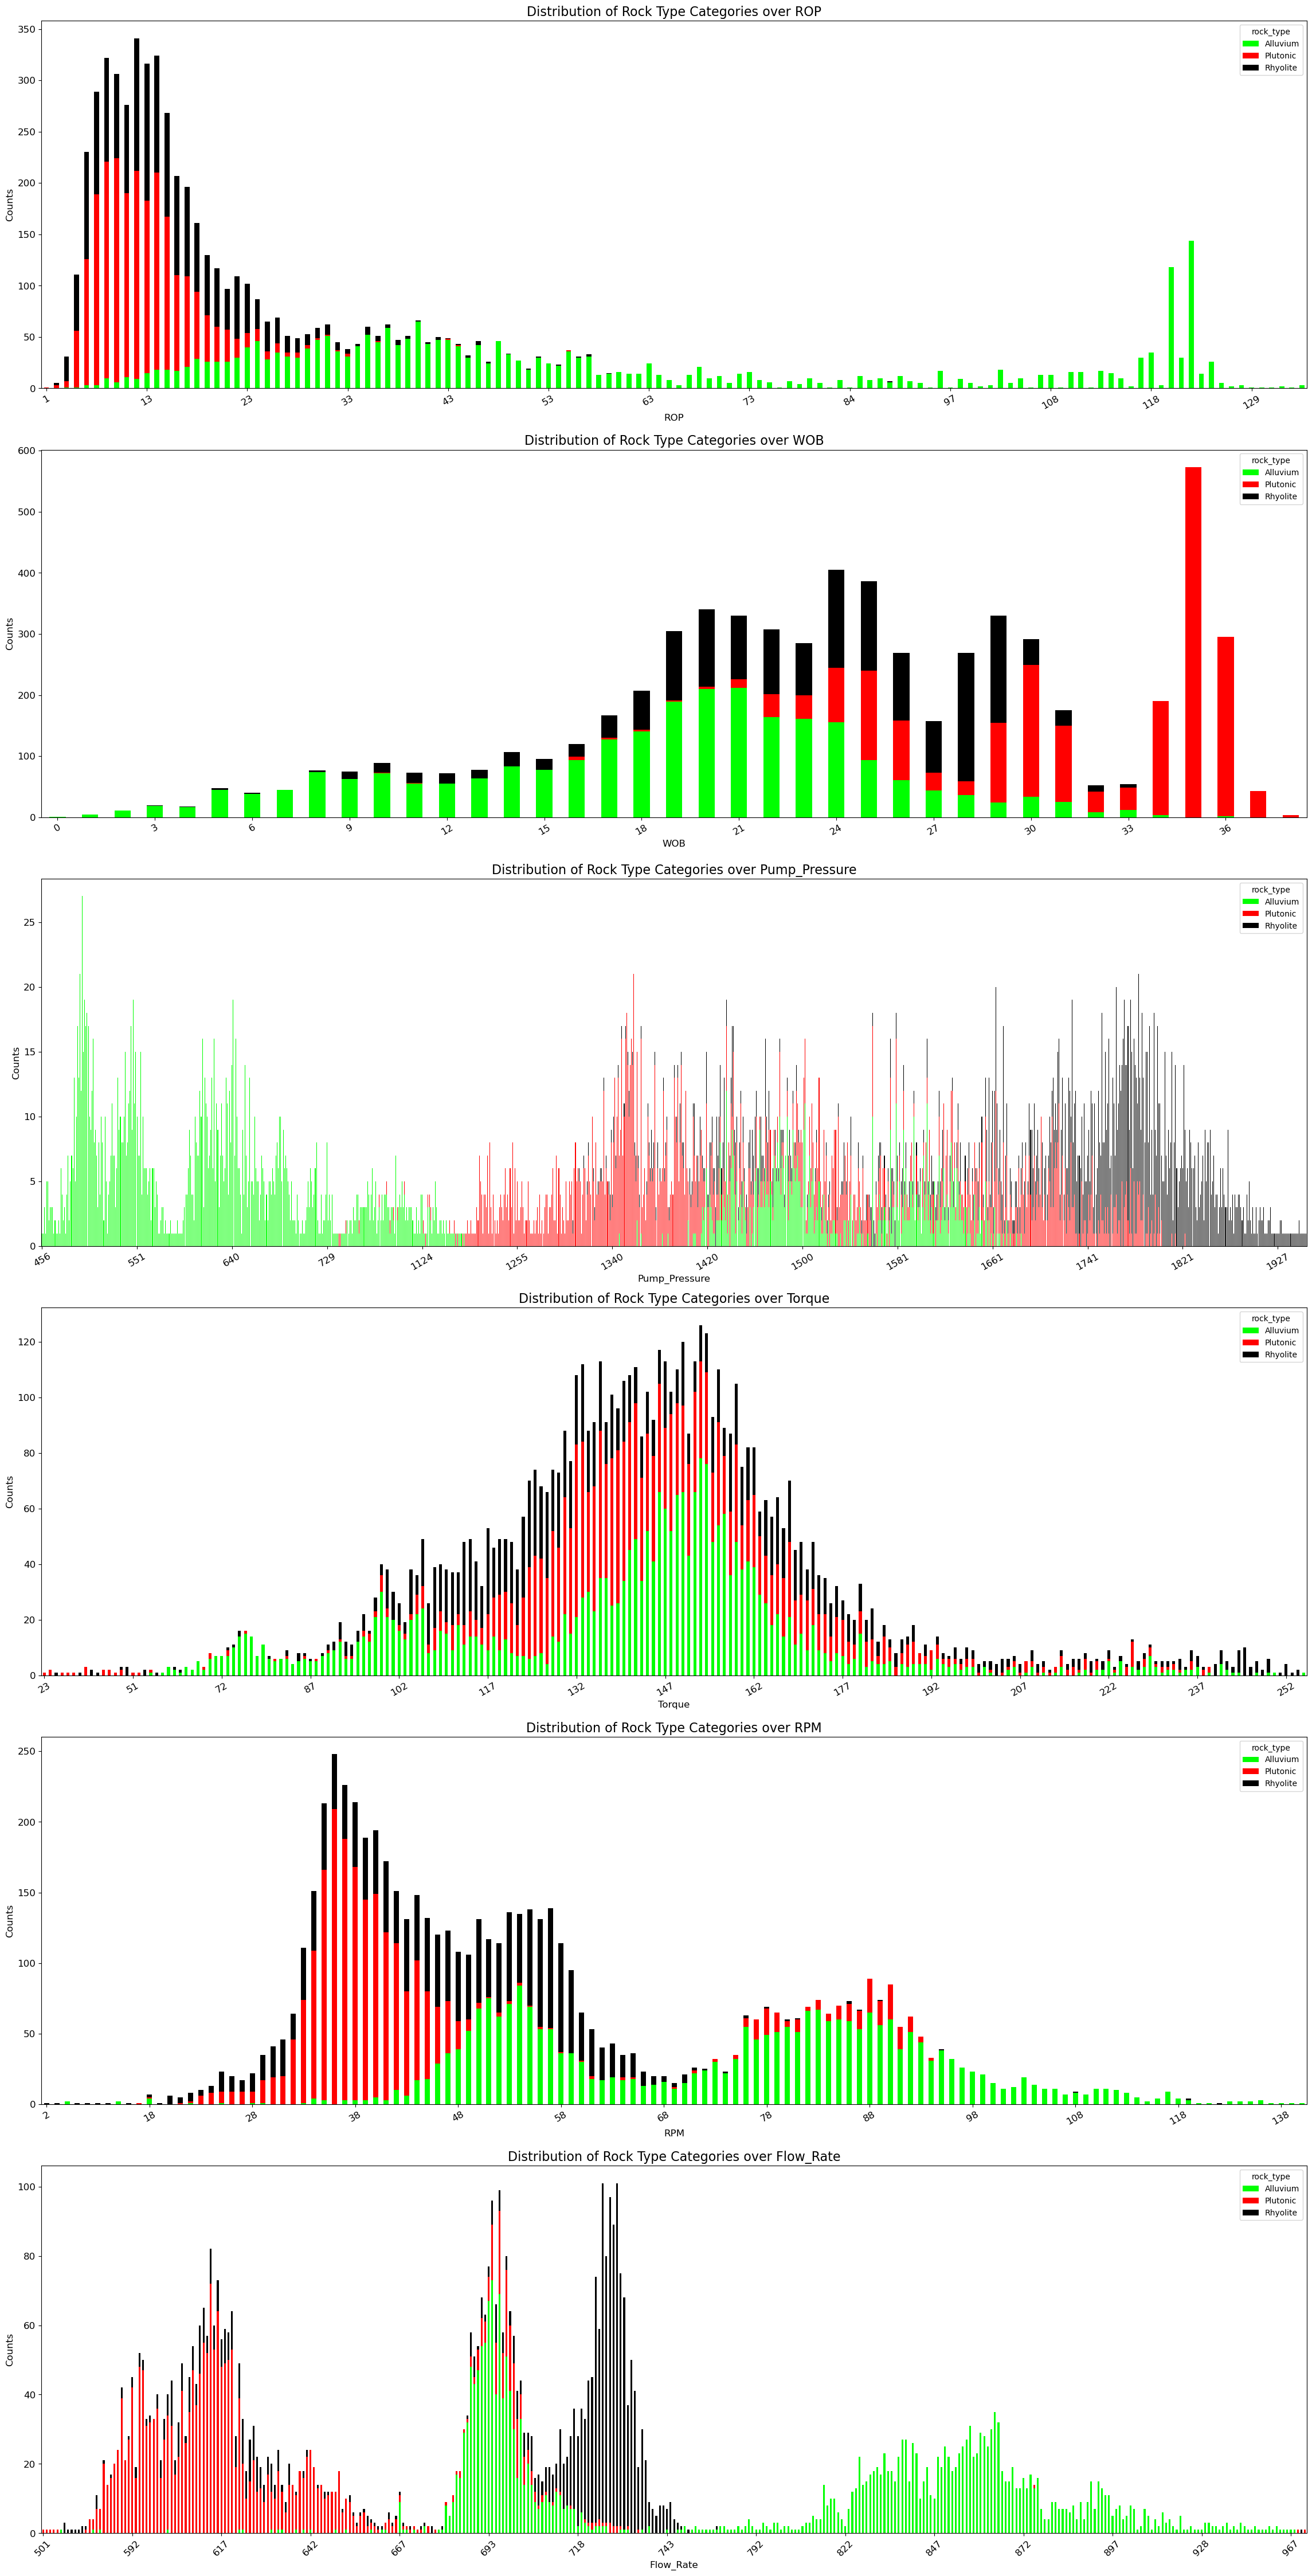

In [23]:
# Function to group data, reset index, and pivot for easier plotting
def prepare_data(df, index_col, category_col='rock_type'):
    grouped = df.groupby([category_col, index_col]).size().reset_index().pivot(
        columns=category_col, index=index_col, values=0)
    return grouped

df_ = df.copy()

# Define the category column that should not be changed
category_column = 'rock_type'

# Find columns to convert (all except the category column)
columns_to_convert = df_.columns[df_.columns != category_column]

# Convert and round these columns
df_[columns_to_convert] = df_[columns_to_convert].apply(lambda x: np.round(x).astype(int))

# Prepare data for each feature
explore1 = prepare_data(df_, 'ROP')
explore2 = prepare_data(df_, 'WOB')
explore3 = prepare_data(df_, 'Pump_Pressure')
explore4 = prepare_data(df_, 'Torque')
explore5 = prepare_data(df_, 'RPM')
explore6 = prepare_data(df_, 'Flow_Rate')

# Setup plot
fig, axes = plt.subplots(6, 1, figsize=(23, 45))

# Define color mapping
colors = ['#00FF00', '#FF0000', '#000000']  # Green, Red, Black

# Plot each feature
explorations = [explore1, explore2, explore3, explore4, explore5, explore6]
for i, explore in enumerate(explorations):
    explore.plot(kind='bar', stacked=True, color=colors, ax=axes[i])
    axes[i].set_title('Distribution of Rock Type Categories over ' + explore.index.name, fontsize = 16)
    axes[i].set_xlabel(explore.index.name, fontsize=12)
    axes[i].set_ylabel('Counts', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=12, labelrotation=30) # Rotate x-axis labels to the right
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(15))  # Set x-axis major tick locator

# Adjust layout
plt.tight_layout()  # Adjust subplots to fit into the figure area neatly
plt.xticks(rotation=45)
plt.show()

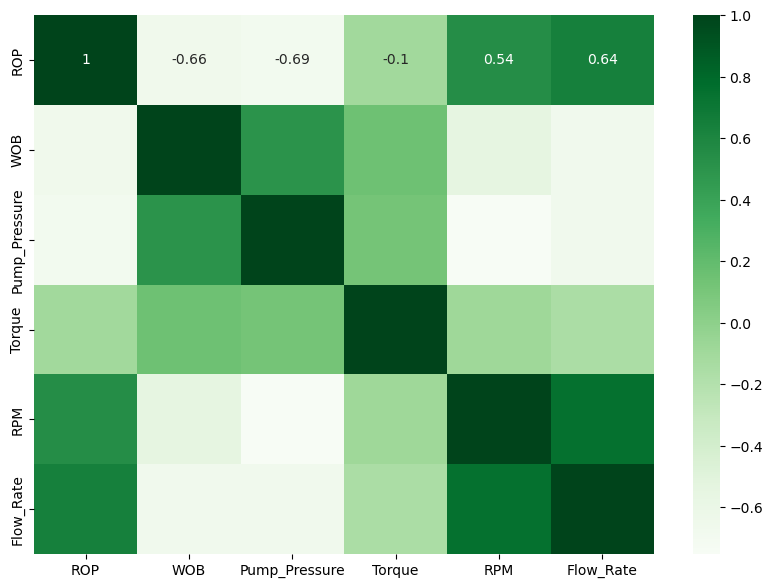

In [24]:
# make a correlation plot (heatmap) to visualize the numerical variables
corr_mx = df[['ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate']].corr()
f, ax = plt.subplots(figsize=(10,7))
ax = sns.heatmap(corr_mx, annot=True, annot_kws={'size':10}, cmap='Greens')

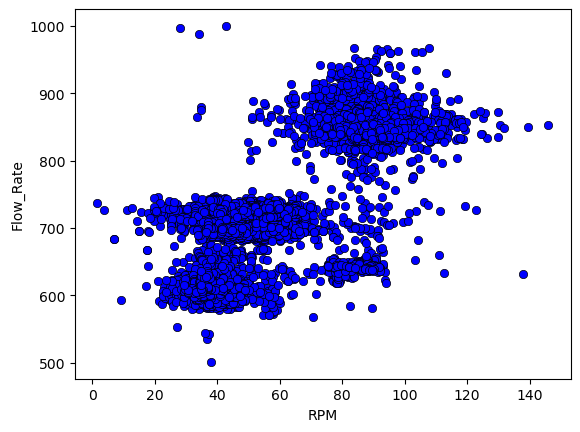

In [25]:
plt.scatter(x=df['RPM'], y=df['Flow_Rate'], 
            color="blue", edgecolors="#000000", linewidths=0.5);
plt.xlabel("RPM"); plt.ylabel("Flow_Rate");

<left>
    <h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
        4. Feature Engineering
    </h1>
</left>

<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            4.1. Feature Split
        </span>    
    </h5>
</left>

In [26]:
df.rock_type.value_counts()

rock_type
Alluvium    2523
Plutonic    2134
Rhyolite    1754
Name: count, dtype: int64

In [27]:
X = df.drop(columns = 'rock_type')
y = df[['rock_type']]

In [28]:
# Define the mapping function
rock_type_mapping = {
    'Alluvium': 0,
    'Rhyolite': 1,
    'Plutonic': 2
}

# Apply the mapping
y['rock_type'] = y['rock_type'].map(rock_type_mapping)

In [29]:
# split data into train and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

print(X_train.shape, y_train.value_counts())
print()
print(X_valid.shape, y_valid.value_counts())

(5128, 6) rock_type
0            2018
2            1707
1            1403
Name: count, dtype: int64

(1283, 6) rock_type
0            505
2            427
1            351
Name: count, dtype: int64


<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            4.2. Feature Preprocessing
        </span>    
    </h5>
</left>

In [30]:
def transform_data(X, numerical_cols):
    
    # Initialize scalers
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    
    # Apply Scaler to df
    scaler.fit(X[numerical_cols])
    X[numerical_cols] = scaler.transform(X[numerical_cols])
    
    return X, scaler

In [31]:
# Define numerical columns
numerical_cols = ['ROP', 'WOB', 'Pump_Pressure', 'Torque', 'RPM', 'Flow_Rate']

# Transform the training data
X_train, scaler = transform_data(X_train, numerical_cols)

In [32]:
# Transform the test data
X_valid = scaler.transform(X_valid)

<left>
    <h1 style="background-color:blue; color:white; font-weight:bold; padding:10px;">
        5. Model Development
    </h1>
</left>

In [65]:
def stratified_k_fold_cv(X_train_scaled, y_train, model, n_splits=5, random_state=42):
    
    # Initialize StratifiedKFold
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    # Lists to store metrics
    train_f1_score_lst = []
    test_f1_score_lst = []
    train_recall_lst = []
    test_recall_lst = []
    train_precision_lst = []
    test_precision_lst = []
    
    fold = 1

    # Perform Stratified K-Fold CV
    for train_index_ls, validation_index_ls in kf.split(X_train_scaled, y_train):
        # Splitting the data
        train, validation = X_train_scaled.iloc[train_index_ls], X_train_scaled.iloc[validation_index_ls]
        target_train, target_val = y_train.iloc[train_index_ls], y_train.iloc[validation_index_ls]
        
        # Fit the model
        model.fit(train, target_train)

        # Predictions on the validation set
        train_preds = model.predict(train)
        validation_preds = model.predict(validation)

        # Calculating metrics for training set
        train_recall_lst.append(recall_score(target_train, train_preds, average='macro'))
        train_precision_lst.append(precision_score(target_train, train_preds, average='macro'))
        train_f1_score_lst.append(f1_score(target_train, train_preds, average='macro'))
        
        # Calculating metrics for validation set
        test_recall_lst.append(recall_score(target_val, validation_preds, average='macro'))
        test_precision_lst.append(precision_score(target_val, validation_preds, average='macro'))
        test_f1_score_lst.append(f1_score(target_val, validation_preds, average='macro'))
        
        fold += 1
    
    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'Train F1 Score': train_f1_score_lst,
        'Test F1 Score': test_f1_score_lst,
        'Train Recall': train_recall_lst,
        'Test Recall': test_recall_lst,
        'Train Precision': train_precision_lst,
        'Test Precision': test_precision_lst
    })

    # Format the DataFrame to 4 decimal places
    pd.options.display.float_format = '{:.4f}'.format
    display(results_df)

    # Calculate means and standard deviations of the metrics
    metrics = {
        'mean_train_recall': np.mean(train_recall_lst),
        'mean_test_recall': np.mean(test_recall_lst),
        'mean_train_precision': np.mean(train_precision_lst),
        'mean_test_precision': np.mean(test_precision_lst),
        'mean_train_f1_score': np.mean(train_f1_score_lst),
        'mean_test_f1_score': np.mean(test_f1_score_lst),
        'std_train_recall': np.std(train_recall_lst),
        'std_test_recall': np.std(test_recall_lst),
        'std_train_precision': np.std(train_precision_lst),
        'std_test_precision': np.std(test_precision_lst),
        'std_train_f1_score': np.std(train_f1_score_lst),
        'std_test_f1_score': np.std(test_f1_score_lst)
    }
    
    # Plotting F1 scores for each fold
    plt.figure(figsize=(10, 6))
    folds = list(range(1, len(train_f1_score_lst) + 1))
    plt.plot(folds, train_f1_score_lst, label='Train F1 Score', marker='o', color='blue')
    plt.plot(folds, test_f1_score_lst, label='Test F1 Score', marker='o',  color='red')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title('Train and Test F1 Scores for each Fold')
    plt.legend()
    plt.ylim([0, 1.1])
    #plt.grid(True)
    plt.show()
    
    # Display cross-validated scores
    print('\nThe following represent the mean of the cross validation metrics across all folds:')
    print("Mean Train Recall: {:.4f}".format(metrics['mean_train_recall']))
    print("Mean Test Recall: {:.4f}".format(metrics['mean_test_recall']))
    print()
    print("Mean Train Precision: {:.4f}".format(metrics['mean_train_precision']))
    print("Mean Test Precision: {:.4f}".format(metrics['mean_test_precision']))
    print()
    print("Mean Train F1 Score: {:.4f}".format(metrics['mean_train_f1_score']))
    print("Mean Test F1 Score: {:.4f}".format(metrics['mean_test_f1_score']))
    print()
    print('The following represent the standard deviation of the cross validation metrics across all folds:')
    print("Std Train Recall: {:.4f}".format(metrics['std_train_recall']))
    print("Std Test Recall: {:.4f}".format(metrics['std_test_recall']))
    print()
    print("Std Train Precision: {:.4f}".format(metrics['std_train_precision']))
    print("Std Test Precision: {:.4f}".format(metrics['std_test_precision']))
    print()
    print("Std Train F1 Score: {:.4f}".format(metrics['std_train_f1_score']))
    print("Std Test F1 Score: {:.4f}".format(metrics['std_test_f1_score']))

In [60]:
def model_evaluation(X_train, y_train, X_test, y_test, model):
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict on the training set
    train_preds = model.predict(X_train)

    # Calculate training evaluation metrics
    train_balanced_accuracy = balanced_accuracy_score(y_train, train_preds)
    train_precision = precision_score(y_train, train_preds, average='macro')
    train_recall = recall_score(y_train, train_preds, average='macro')
    train_f1_score = f1_score(y_train, train_preds, average='macro')

    # Print the training evaluation metrics
    print("\nEvaluation on Training Set:")
    print("Balanced Accuracy: {:.4f}".format(train_balanced_accuracy))
    print("Precision: {:.4f}".format(train_precision))
    print("Recall: {:.4f}".format(train_recall))
    print("F1-Score: {:.4f}".format(train_f1_score))
    print(classification_report(y_train, train_preds))
    print()

    # Predict on the test set
    test_preds = model.predict(X_test)

    # Calculate test evaluation metrics
    test_balanced_accuracy = balanced_accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds, average='macro')
    test_recall = recall_score(y_test, test_preds, average='macro')
    test_f1_score = f1_score(y_test, test_preds, average='macro')

    # Print the test evaluation metrics
    print("\nFinal Evaluation on Test Set:")
    print("Balanced Accuracy: {:.4f}".format(test_balanced_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-Score: {:.4f}".format(test_f1_score))
    print(classification_report(y_test, test_preds))

In [61]:
def optimize_rf(X_train, y_train, model, cv, max_evals):
    # Define a function to optimize the Random Forest hyperparameters

    def objective(params):
        # Convert parameters to the appropriate types
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['max_features'] = int(params['max_features'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_samples_leaf'] = int(params['min_samples_leaf'])
        params['criterion'] = str(params['criterion'])

        # Initialize the Random Forest classifier with given parameters
        clf = RandomForestClassifier(**params)

        # Lists to store F1 scores for training and validation sets
        train_f1s = []
        val_f1s = []

        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            # Split the data into training and validation sets
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            # Train the classifier on the training set
            clf.fit(X_t, y_t)

            # Predict on the training and validation sets
            train_preds = clf.predict(X_t)
            val_preds = clf.predict(X_v)

            # Calculate F1 scores for training and validation sets
            train_f1 = f1_score(y_t, train_preds, average='macro')
            val_f1 = f1_score(y_v, val_preds, average='macro')

            # Append the scores to the respective lists
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)

        # Calculate mean F1 scores for training and validation sets
        mean_train_f1 = np.mean(train_f1s)
        mean_val_f1 = np.mean(val_f1s)

        # Calculate the difference between training and validation scores
        diff = mean_train_f1 - mean_val_f1

        # Apply penalty if the difference is greater than 0.05
        if diff > 0.05:
            penalty = diff
        else:
            penalty = 0

        # Calculate the final score by subtracting the penalty from validation score
        score = mean_val_f1 - penalty

        # Return the loss (negative score) and other relevant information
        return {'loss': -score, 'status': STATUS_OK, 'params': params, 'train_f1': mean_train_f1, 'val_f1': mean_val_f1}

    # Define the hyperparameter space for optimization
    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 10000, 1),
        'max_depth': hp.quniform('max_depth', 1, 1000, 1),
        'max_features': hp.quniform('max_features', 1, 6, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

    # Initialize a Trials object to store the results of each trial
    trials = Trials()

    # Use the fmin function from hyperopt to find the best hyperparameters
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # Extract information from the best trial
    best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
    best_params = best_trial['result']['params']
    best_train_f1 = best_trial['result']['train_f1']
    best_val_f1 = best_trial['result']['val_f1']

    # Print the best parameters and corresponding F1 scores
    print(f"Best Parameters: {best_params}")
    print(f"Training F1: {best_train_f1}")
    print(f"Validation F1: {best_val_f1}")

    # Plot training and validation scores for each trial
    iterations = list(range(len(trials.trials)))
    train_f1s = [trial['result']['train_f1'] for trial in trials.trials]
    val_f1s = [trial['result']['val_f1'] for trial in trials.trials]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_f1s, label='Training F1', marker='o', color='blue')
    plt.plot(iterations, val_f1s, label='Validation F1', marker='o', color='red')
    plt.xlabel('Trial')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 over Trials')
    plt.ylim([0,1.1])
    plt.legend()
    plt.show()

    # Plot training and validation scores for each numeric hyperparameter
    numeric_params = ['n_estimators', 'max_depth', 'max_features', 'min_samples_split', 'min_samples_leaf']
    for param in numeric_params:
        values = [trial['result']['params'][param] for trial in trials.trials]
        if len(set(values)) >= 5:  # Ensure at least 5 different values explored
            plt.figure(figsize=(10, 6))
            plt.scatter(values, train_f1s, label='Training F1', marker='o', color='blue', edgecolors='black')
            plt.scatter(values, val_f1s, label='Validation F1', marker='o', color='red', edgecolors='black')
            plt.xlabel(param)
            plt.ylabel('F1 Score')
            plt.title(f'Training and Validation F1 vs {param}')
            plt.ylim([0,1.1])
            plt.legend()
            plt.show()

    return best_params, best_train_f1, best_val_f1, trials
    # Return the best parameters and corresponding F1 scores along with the trials object


<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            5.1. Baseline Model: Training
        </span>    
    </h5>
</left>

Fold  Train F1 Score  Test F1 Score  Train Recall  Test Recall  \
0     1          1.0000         0.9833        1.0000       0.9831   
1     2          1.0000         0.9828        1.0000       0.9830   
2     3          1.0000         0.9713        1.0000       0.9710   
3     4          1.0000         0.9854        1.0000       0.9855   
4     5          1.0000         0.9819        1.0000       0.9814   

   Train Precision  Test Precision  
0           1.0000          0.9835  
1           1.0000          0.9827  
2           1.0000          0.9717  
3           1.0000          0.9852  
4           1.0000          0.9823

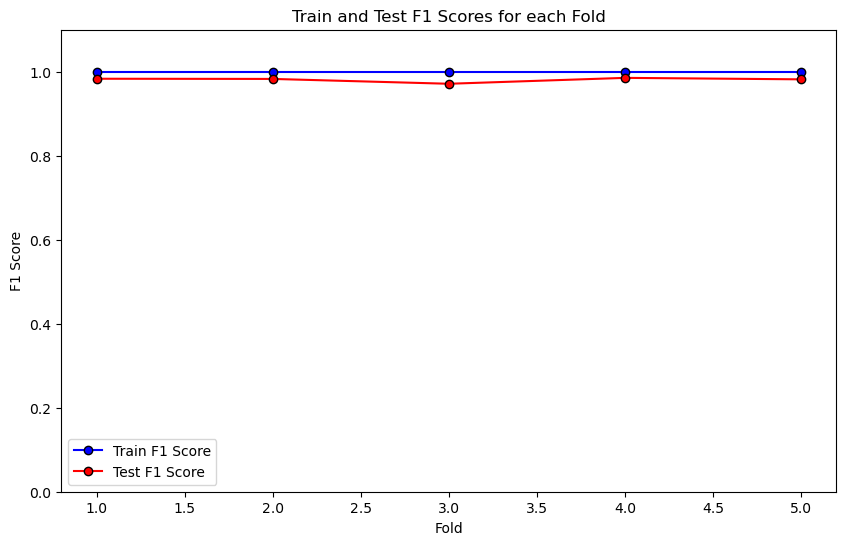


The following represent the mean of the cross validation metrics across all folds:
Mean Train Recall: 1.0000
Mean Test Recall: 0.9808

Mean Train Precision: 1.0000
Mean Test Precision: 0.9811

Mean Train F1 Score: 1.0000
Mean Test F1 Score: 0.9809

The following represent the standard deviation of the cross validation metrics across all folds:
Std Train Recall: 0.0000
Std Test Recall: 0.0051

Std Train Precision: 0.0000
Std Test Precision: 0.0048

Std Train F1 Score: 0.0000
Std Test F1 Score: 0.0049


In [36]:
# Define Model Object
model_rf = RandomForestClassifier(random_state = 42)

# Cross validate the model object on the training data
stratified_k_fold_cv(X_train, y_train, model_rf)

In [39]:
model_evaluation(X_train, y_train, X_valid, y_valid, model_rf)


Evaluation on Training Set:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2018
           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00      1707

    accuracy                           1.00      5128
   macro avg       1.00      1.00      1.00      5128
weighted avg       1.00      1.00      1.00      5128



Final Evaluation on Test Set:
Balanced Accuracy: 0.9778
Precision: 0.9780
Recall: 0.9778
F1-Score: 0.9779
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       505
           1       0.97      0.96      0.96       351
           2       0.97      0.98      0.98       427

    accuracy                           0.98      1283
   macro avg       0.98      0.98      0.98      1283
weighted avg       0.98      0.98      0.98      1283



<left>
    <h5> 
        <span style="background-color:blue; color:white; font-weight:bold; padding:10px;">
            5.2. Tuned Model: Hyperparameter Tuning
        </span>    
    </h5>
</left>

100%|██████████| 5/5 [22:46<00:00, 273.28s/trial, best loss: -0.9813643450050552]
Best Parameters: {'criterion': 'entropy', 'max_depth': 361, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 2739}
Training F1: 0.9994590437541806
Validation F1: 0.9813643450050552


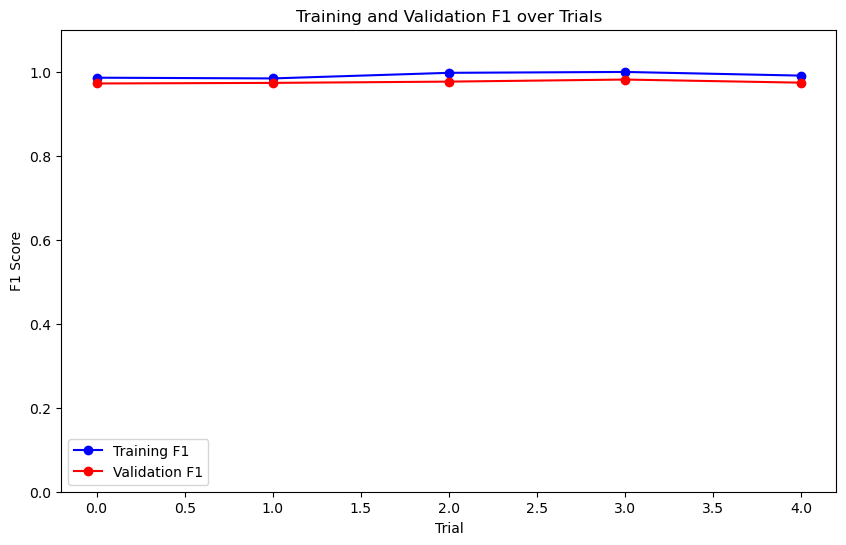

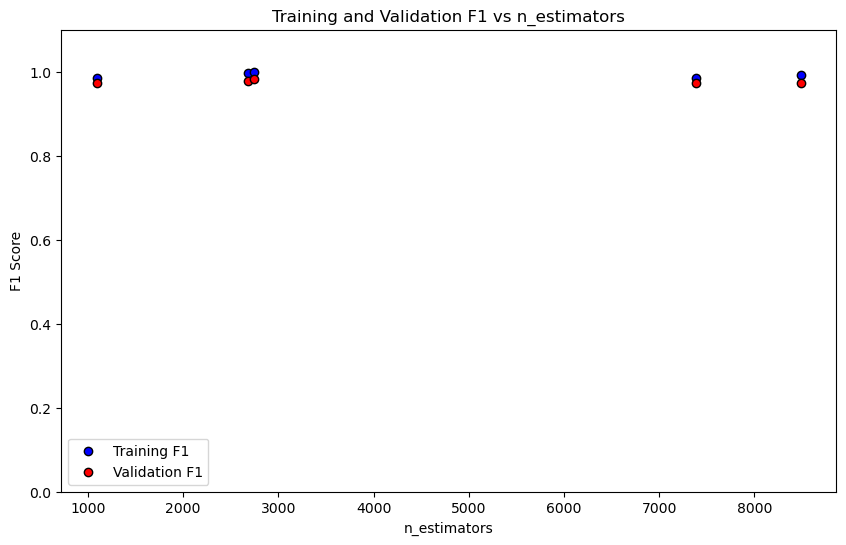

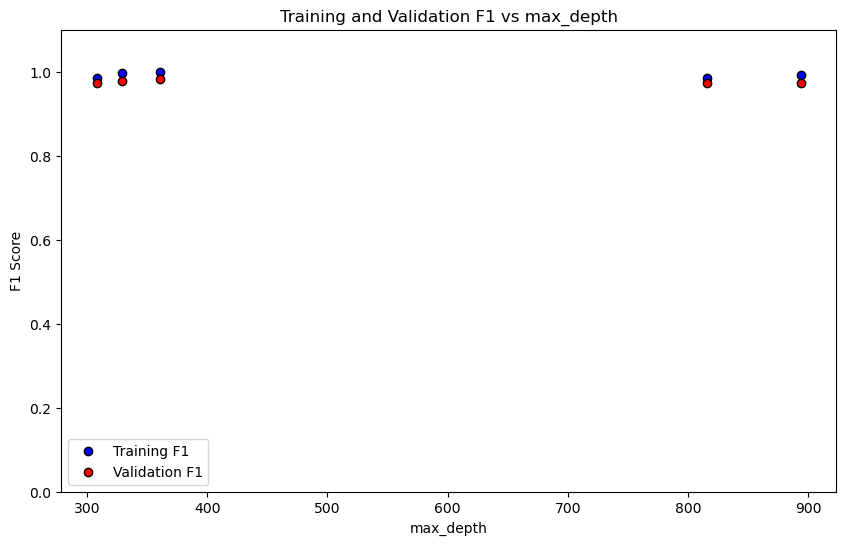

Best Train F1-Score: 0.9994590437541806
Best Test F1-Score: 0.9813643450050552
CPU times: total: 13min 33s
Wall time: 22min 47s


In [51]:
%%time
# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
X_train_ = np.array(X_train)
y_train_ = np.array(y_train)
# Run Hyperparameter Tuning
best_params, best_train_f1, best_val_f1, trials = optimize_rf(X_train_, y_train_, model_rf, cv=cv, max_evals=5)
print(f'Best Train F1-Score: {best_train_f1}')
print(f'Best Test F1-Score: {best_val_f1}')

In [56]:
# Define Model Object
model_rf_tuned = RandomForestClassifier(**best_params, random_state = 42)

Fold  Train F1 Score  Test F1 Score  Train Recall  Test Recall  \
0     1          0.9995         0.9844        0.9995       0.9841   
1     2          0.9995         0.9861        0.9995       0.9864   
2     3          0.9987         0.9713        0.9987       0.9708   
3     4          1.0000         0.9832        1.0000       0.9831   
4     5          0.9992         0.9808        0.9993       0.9801   

   Train Precision  Test Precision  
0           0.9994          0.9846  
1           0.9994          0.9858  
2           0.9986          0.9719  
3           1.0000          0.9833  
4           0.9991          0.9816

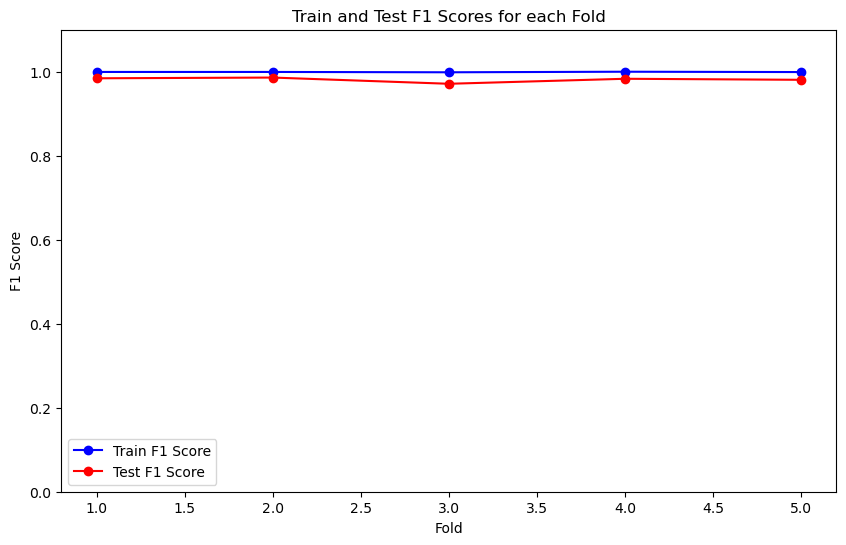


The following represent the mean of the cross validation metrics across all folds:
Mean Train Recall: 0.9994
Mean Test Recall: 0.9809

Mean Train Precision: 0.9993
Mean Test Precision: 0.9814

Mean Train F1 Score: 0.9994
Mean Test F1 Score: 0.9811

The following represent the standard deviation of the cross validation metrics across all folds:
Std Train Recall: 0.0004
Std Test Recall: 0.0054

Std Train Precision: 0.0005
Std Test Precision: 0.0050

Std Train F1 Score: 0.0004
Std Test F1 Score: 0.0052


In [66]:
# Cross validate the model object on the training data
stratified_k_fold_cv(X_train, y_train, model_rf_tuned)

In [67]:
model_evaluation(X_train, y_train, X_valid, y_valid, model_rf_tuned)


Evaluation on Training Set:
Balanced Accuracy: 0.9996
Precision: 0.9995
Recall: 0.9996
F1-Score: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2018
           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00      1707

    accuracy                           1.00      5128
   macro avg       1.00      1.00      1.00      5128
weighted avg       1.00      1.00      1.00      5128



Final Evaluation on Test Set:
Balanced Accuracy: 0.9769
Precision: 0.9772
Recall: 0.9769
F1-Score: 0.9770
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       505
           1       0.97      0.96      0.96       351
           2       0.97      0.98      0.98       427

    accuracy                           0.98      1283
   macro avg       0.98      0.98      0.98      1283
weighted avg       0.98      0.98      0.98      1283

